In [1]:
import networkx as nx
import numpy as np
from scipy.special import binom
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.metrics import normalized_mutual_info_score
from tqdm import tqdm
import multiprocessing
from time import time
import pickle
from pprint import pprint

from methods import *

np.random.seed(1234)

## About sampling

In [2]:
networks = [
    nx.karate_club_graph().to_undirected(),
    nx.florentine_families_graph().to_undirected(),
    nx.read_gml("dolphins.gml").to_undirected()
]

labels = [
    "Karate Club",
    "Florentine Families",
    "Dolphins"
]

colors = sns.color_palette("husl", len(networks))

In [ ]:
# Transient and NMI
max_iter_transient = 5000
max_iter_nmi = 5001

transient = np.zeros((len(networks), max_iter_transient+1))
nmi = np.zeros((len(networks), max_iter_nmi))

for i, G in enumerate(networks):
    # Create the adjacency matrix
    A = nx.adjacency_matrix(G).todense()
    A = (A > 0).astype(int)
    N = A.shape[0]

    # Groups data structure: list of lists
    groups = [[] for _ in range(N)]

    # Uniformly random initialization
    for j in range(N): 
        g = np.random.randint(0, N)
        groups[g].append(j)

    # Transient time (to test convergence)
    H = hamiltonian(A, groups)
    transient[i, 0] = H
    for k in tqdm(range(max_iter_transient)):
        groups, H = singleStep(groups, H, A)
        transient[i, k+1] = H

    # NMI
    belongs_to = arrayGroups(groups)
    for k in tqdm(range(max_iter_nmi)):
        groups, H = singleStep(groups, H, A)
        nmi[i, k] = normalized_mutual_info_score(belongs_to, arrayGroups(groups))

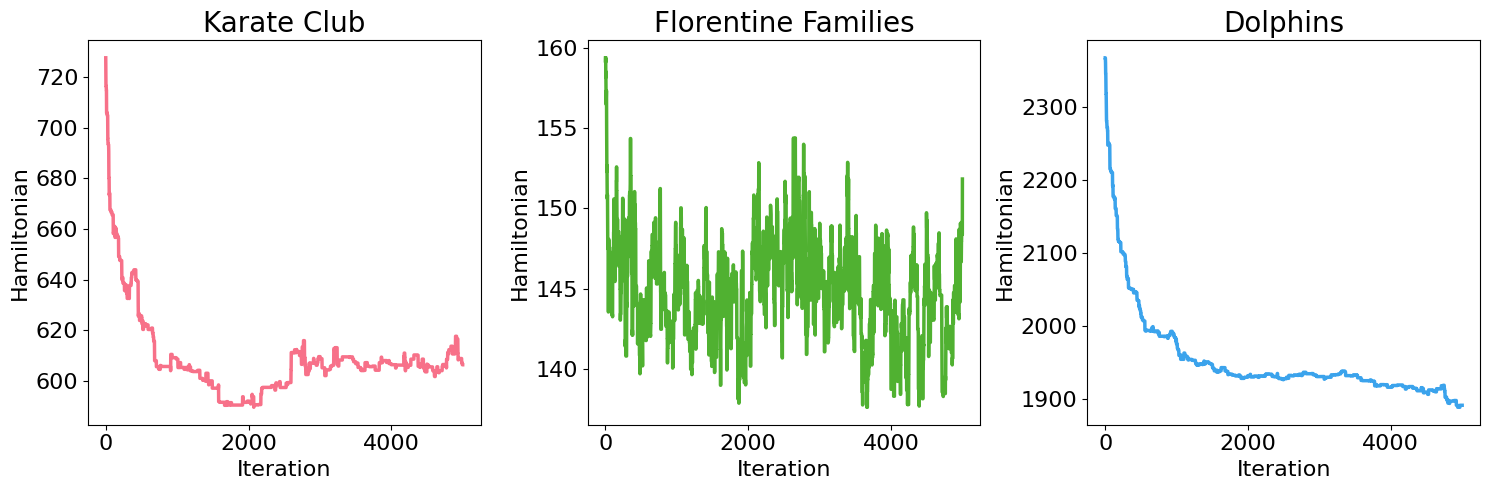

In [60]:
fontsize_label = 16
fontsize_title = 20

x = np.arange(max_iter_transient+1)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(len(networks)):
    ax[i].plot(x, transient[i], color=colors[i], linewidth=2.5)
    ax[i].set_title(f"{labels[i]}", fontsize=fontsize_title)
    ax[i].set_xlabel("Iteration", fontsize=fontsize_label)
    ax[i].set_ylabel("Hamiltonian", fontsize=fontsize_label)
    ax[i].tick_params(axis='both', which='major', labelsize=fontsize_label)
    ax[i].tick_params(axis='both', which='minor', labelsize=fontsize_label)
    #ax[i].grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

#fig.suptitle("Transient time", fontsize=1.5*fontsize_title)
plt.tight_layout()

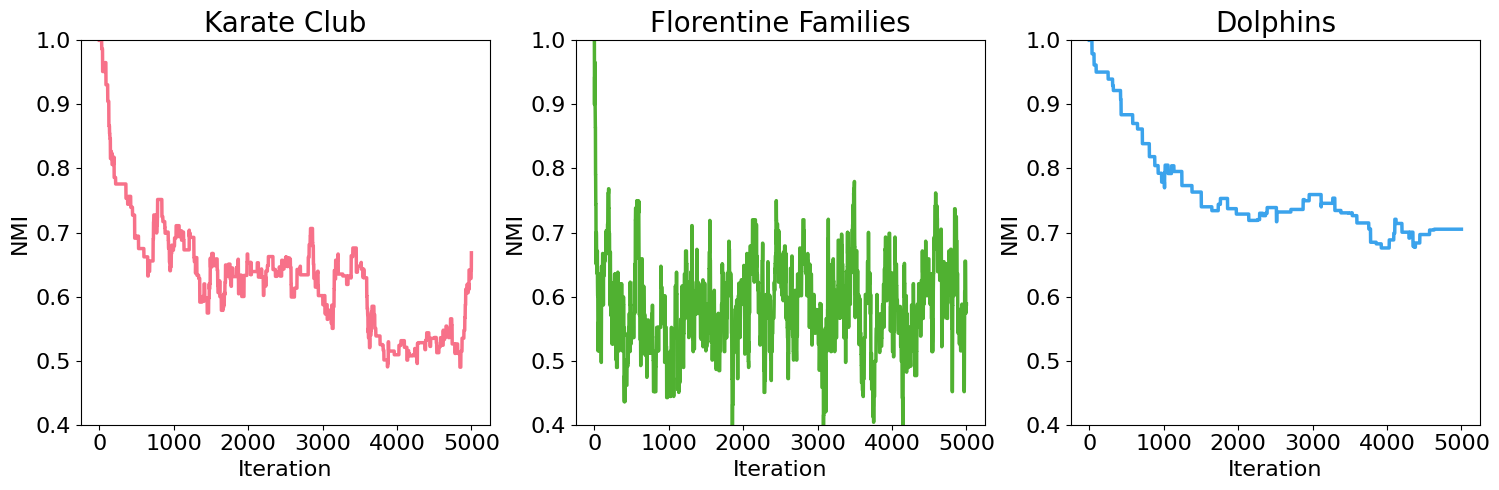

In [61]:
fontsize_label = 16
fontsize_title = 20

x = np.arange(max_iter_nmi)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(len(networks)):
    ax[i].plot(x, nmi[i], color=colors[i], linewidth=2.5)
    ax[i].set_title(f"{labels[i]}", fontsize=fontsize_title)
    ax[i].set_xlabel("Iteration", fontsize=fontsize_label)
    ax[i].set_ylabel("NMI", fontsize=fontsize_label)
    ax[i].tick_params(axis='both', which='major', labelsize=fontsize_label)
    ax[i].tick_params(axis='both', which='minor', labelsize=fontsize_label)
    ax[i].set_ylim([0.4, 1])
    #ax[i].grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

#fig.suptitle("NMI", fontsize=1.5*fontsize_title)
plt.tight_layout()

## Code

### Visual

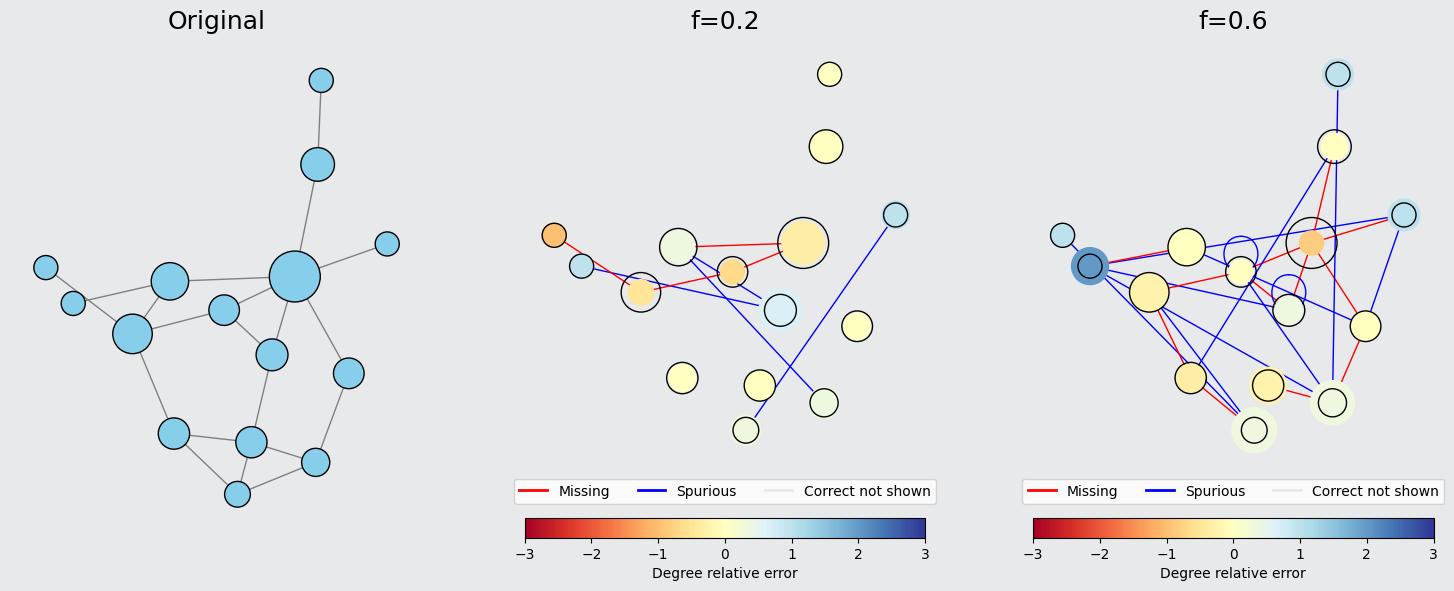

In [4]:
G = nx.florentine_families_graph().to_undirected()
A = nx.adjacency_matrix(G).todense()
A = (A > 0).astype(int)

A_1 = corruptAdjacencyMatrix(A, p=0.2, mode='both')
A_2 = corruptAdjacencyMatrix(A, p=0.6, mode='both')

fig, ax = plotGraphsComparison(A, A_1, A_2, 
                               titles=["Original", "f=0.2", "f=0.6"], fontsize=18)
fig.show()

## From logs

### Reliability scan

In [7]:
p_vec_net = np.arange(0.05, 0.55, 0.05)

In [9]:
networks = [
    "karate_club", 
    "florentine_families",
    "dolphins"
]

p_vec_link = np.arange(0.05, 1, 0.05)

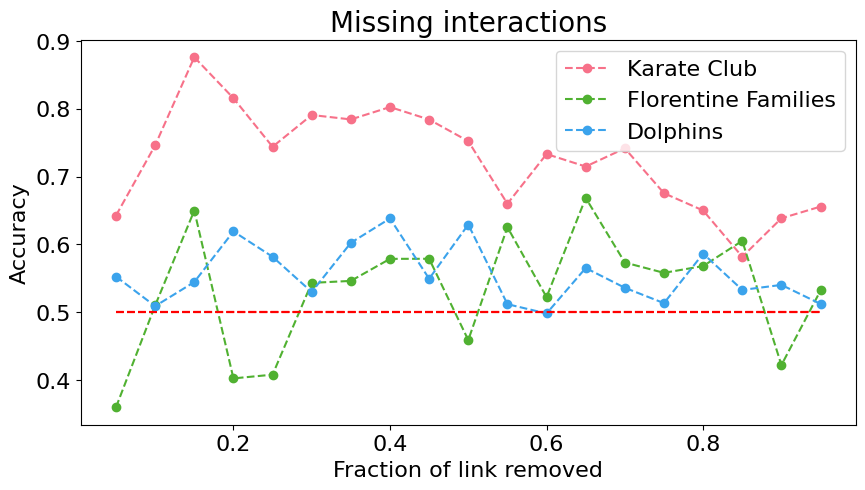

In [14]:
# Missing interactions
fontsize_label = 16
fontsize_title = 20

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i, net in enumerate(networks):
    with open(f"./logs/scan_{net}.pkl", "rb") as file:
        results = pickle.load(file)

    ax.plot(p_vec_link, results["missing"], 'o--', label=labels[i], color=colors[i])
    ax.hlines(0.5, p_vec_link[0], p_vec_link[-1], color='red', linestyle='--')

    ax.set_xlabel("Fraction of link removed", fontsize=fontsize_label)
    ax.set_ylabel("Accuracy", fontsize=fontsize_label)
    ax.set_title("Missing interactions", fontsize=fontsize_title)

    ax.tick_params(axis='both', which='major', labelsize=fontsize_label)
    ax.tick_params(axis='both', which='minor', labelsize=fontsize_label)

    ax.legend(fontsize=fontsize_label)
    

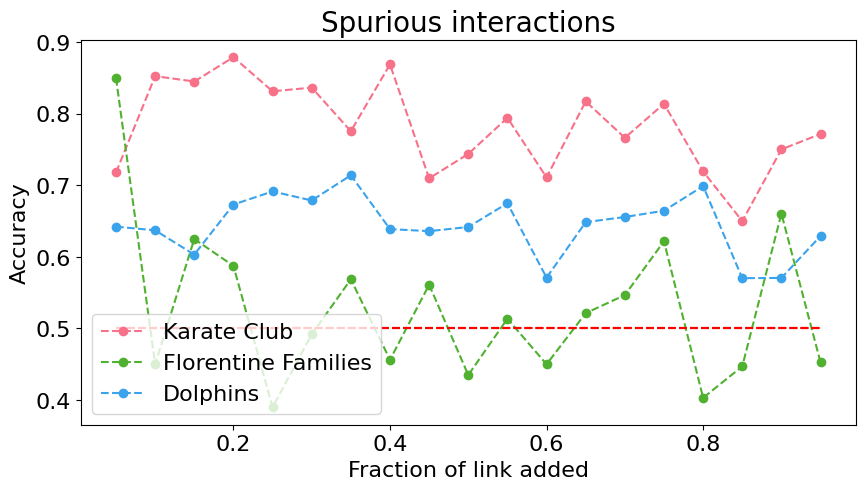

In [15]:
# Spurious interactions
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for i, net in enumerate(networks):
    with open(f"./logs/scan_{net}.pkl", "rb") as file:
        results = pickle.load(file)

    ax.plot(p_vec_link, results["spurious"], 'o--', label=labels[i], color=colors[i])
    ax.hlines(0.5, p_vec_link[0], p_vec_link[-1], color='red', linestyle='--')

    ax.set_xlabel("Fraction of link added", fontsize=fontsize_label)
    ax.set_ylabel("Accuracy", fontsize=fontsize_label)
    ax.set_title("Spurious interactions", fontsize=fontsize_title)

    ax.tick_params(axis='both', which='major', labelsize=fontsize_label)
    ax.tick_params(axis='both', which='minor', labelsize=fontsize_label)

    ax.legend(fontsize=fontsize_label)

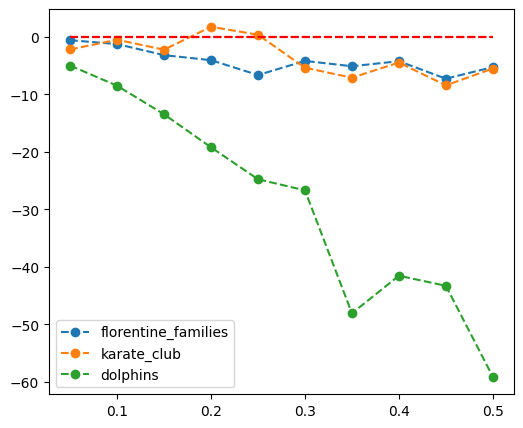

In [7]:
networks = ["florentine_families", "karate_club", "dolphins"]
p_vec_net = np.arange(0.05, 0.55, 0.05)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
for i, net in enumerate(networks):
    with open(f"./logs/scan_{net}.pkl", "rb") as file:
        results = pickle.load(file)

    ax.plot(p_vec_net, results["network"], 'o--', label=net)
    ax.hlines(0, p_vec_net[0], p_vec_net[-1], color='red', linestyle='--') 

    ax.legend()


### Network reconstruction

In [23]:
with open("./logs/netRec_karate_club.pkl", "rb") as file:
    results = pickle.load(file)

pprint(results)

{0.1: {'A_2': array([[0, 1, 1, ..., 1, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]]),
       'A_obs': array([[0, 1, 1, ..., 1, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]]),
       'A_recon': array([[0, 1, 1, ..., 1, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]]),
       'elapsed_time': 61132.81919884682,
       'errors_obs': 16,
       'errors_recon': 40,
       'hist_accepted': [1,
                         1,
                         1,
                         1,
                         1,
                         1,
                         0,
                         0,
                

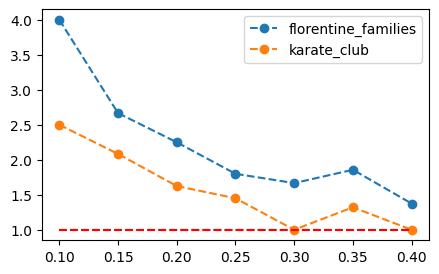

In [24]:
networks = ["florentine_families", "karate_club"]

fig, ax = plt.subplots(1, 1, figsize=(5, 3))

for i, net in enumerate(networks):
    with open(f"./logs/netRec_{net}.pkl", "rb") as file:
        results = pickle.load(file)

    p_list = results["p-list"]
    score = np.zeros(len(p_list))
    for i, p in enumerate(p_list):
        score[i] = results[p]["errors_recon"]/results[p]["errors_obs"]

    ax.plot(p_list, score, 'o--', label=net)
    ax.hlines(1, p_list[0], p_list[-1], color='red', linestyle='--')

    ax.legend()

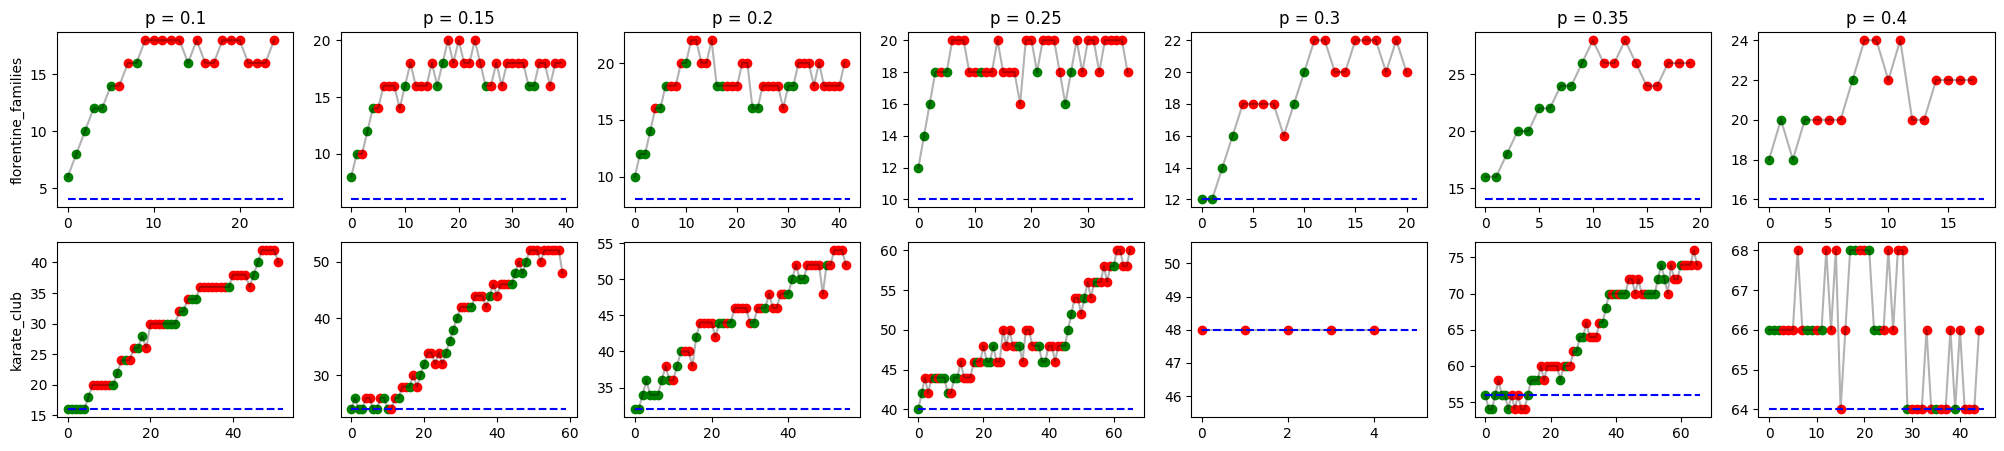

In [41]:
fig, ax = plt.subplots(len(networks), len(p_list), figsize=(25, 5))
for i, net in enumerate(networks):
    with open(f"./logs/netRec_{net}.pkl", "rb") as file:
        results = pickle.load(file)

    for j, p in enumerate(p_list):
        proposed = results[p]["hist_proposed"]
        accepted = results[p]["hist_accepted"]
        init = results[p]["errors_obs"]

        # Create the colormap based on the 'accepted' array
        colormap = np.where(np.array(accepted) == 1, 'green', 'red')
        
        # Plot each point with the corresponding color
        for k in range(len(proposed)):
            ax[i, j].plot(k, proposed[k], marker='o', color=colormap[k])

        ax[i, j].plot(proposed, color='black', alpha=0.3)
        ax[i, j].hlines(init, 0, len(proposed), color='blue', linestyle='--')

        ax[0, j].set_title(f"p = {p}")
    
    ax[i, 0].set_ylabel(net)
